In [ ]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

# 시드 설정 - 동일한 시뮬레이션 결과를 위해 설정
np.random.seed(10)

In [25]:
# Set some general settings, to be used across all simulations
num_signals = 100
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

# Define the components of the combined signal to simulate
n_neurons_range = (800, 1200)  # range for number of neurons
firing_rate_range = (2, 4)     # range for firing rate
t_ker_range = (0.8, 1.2)       # range for t_ker
tau_r_range = (0.001, 0.003)   # range for tau_r
tau_d_range = (0.015, 0.025)   # range for tau_d
freq_range = (1, 50)           # range for oscillation frequency

# 초기 빈 numpy 배열 생성

set_shape_1d = np.zeros(len(times))                     # (4000, )
set_shape_2d = np.zeros((0, len(times)))                # (0,4000)
set_shape_2d_2 = np.zeros((num_signals, len(times)))    # (10000,4000)

# -------- < original signal data > ------------------------------------------------

Clean = set_shape_2d.copy()

In [26]:
for idx in range(num_signals):
    # Sample values from the specified ranges for each signal sample
    n_neurons = np.random.randint(n_neurons_range[0], n_neurons_range[1] + 1)
    firing_rate = np.random.uniform(firing_rate_range[0], firing_rate_range[1])
    t_ker = np.random.uniform(t_ker_range[0], t_ker_range[1])
    tau_r = np.random.uniform(tau_r_range[0], tau_r_range[1])
    tau_d = np.random.uniform(tau_d_range[0], tau_d_range[1])
    freq = np.random.uniform(freq_range[0], freq_range[1])
    
    components = {
        'sim_synaptic_current': {
            'n_neurons': n_neurons,
            'firing_rate': firing_rate,
            't_ker': t_ker,
            'tau_r': tau_r,
            'tau_d': tau_d
        },
        'sim_oscillation': {
            'freq': freq
        }
    }
    
    # Simulate an oscillation over an aperiodic component
    Clean_signal = sim_combined(n_seconds, fs, components)
    
    Clean = np.vstack((Clean, Clean_signal))  # (10000, 4000)


(100, 4000)


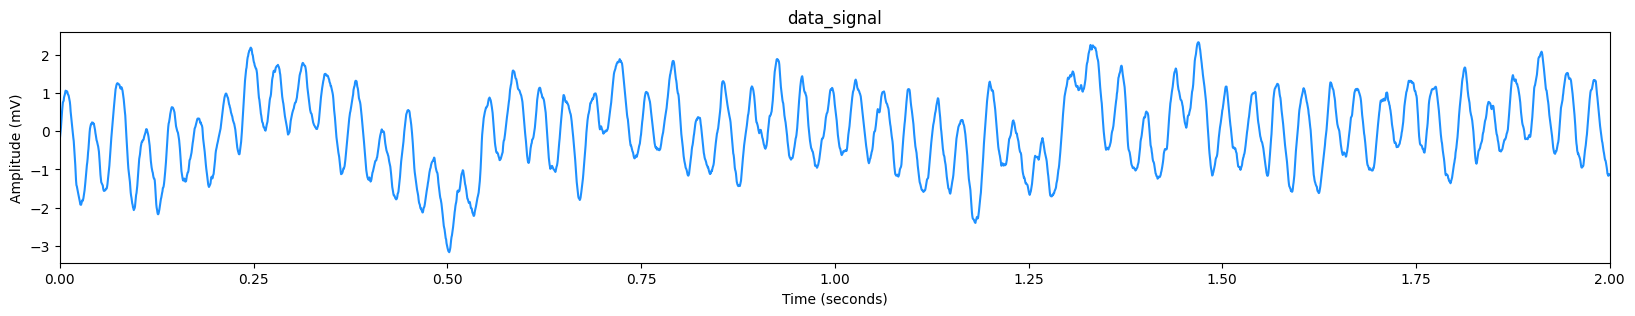

In [27]:
# 확대할 구간 설정
plt.figure(figsize=(20, 3))
plt.plot(times, Clean[0, :], label = 'data signal', c='dodgerblue')
plt.ylabel("Amplitude (mV)"); plt.xlabel("Time (seconds)");plt.title('data_signal')
plt.xlim([0, 2])

print(Clean.shape)

## Artifact 생성

In [28]:
# Generate artifact
frequency = 125
period = 1 / frequency
num_waveforms = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

sine_artifact = set_shape_2d.copy()
asymmetric_artifact = set_shape_2d.copy()
randamplitude_artifact = set_shape_2d_2.copy()

Contaminated = set_shape_2d.copy()
print(num_waveforms)
print(samples_per_period)

250
17


In [29]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation

for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    asymmetric_artifact = np.vstack((asymmetric_artifact, osc_shape))
    
print("data_asymmetric_artifact shape:", asymmetric_artifact.shape) # (10000, 4000)


# 음의 값이 2배가 되도록 y축 shifting
asymmetric_artifact = asymmetric_artifact * 1.75 - 0.75


# randamplitude 추가
# random_amplitudes = np.random.uniform(amplitude_range_mean * 5, amplitude_range_mean * 10, num_signals)
random_amplitudes = np.random.uniform(0.75, 1.25, (num_signals, num_waveforms))

for signal_idx in range(num_signals):
    for waveform_idx in range(num_waveforms):
        start_idx = waveform_idx * samples_per_period
        end_idx = min((waveform_idx + 1) * samples_per_period, len(times))

        if start_idx >= len(times):
            break

        each_period = set_shape_1d.copy()
        each_period[start_idx:end_idx] = asymmetric_artifact[signal_idx, start_idx:end_idx] * random_amplitudes[signal_idx, waveform_idx]
        randamplitude_artifact[signal_idx, start_idx:end_idx] += each_period[start_idx:end_idx]


for i in range(num_signals):
    x = np.min(Clean[i, :]) * 10 / np.min(randamplitude_artifact[i, :])
    Contaminated_signal = Clean[i, :] + randamplitude_artifact[i, :] * x

    Contaminated = np.vstack((Contaminated, Contaminated_signal)) # (10000, 4000)

data_asymmetric_artifact shape: (100, 4000)


data_randamplitude shape: (100, 4000)


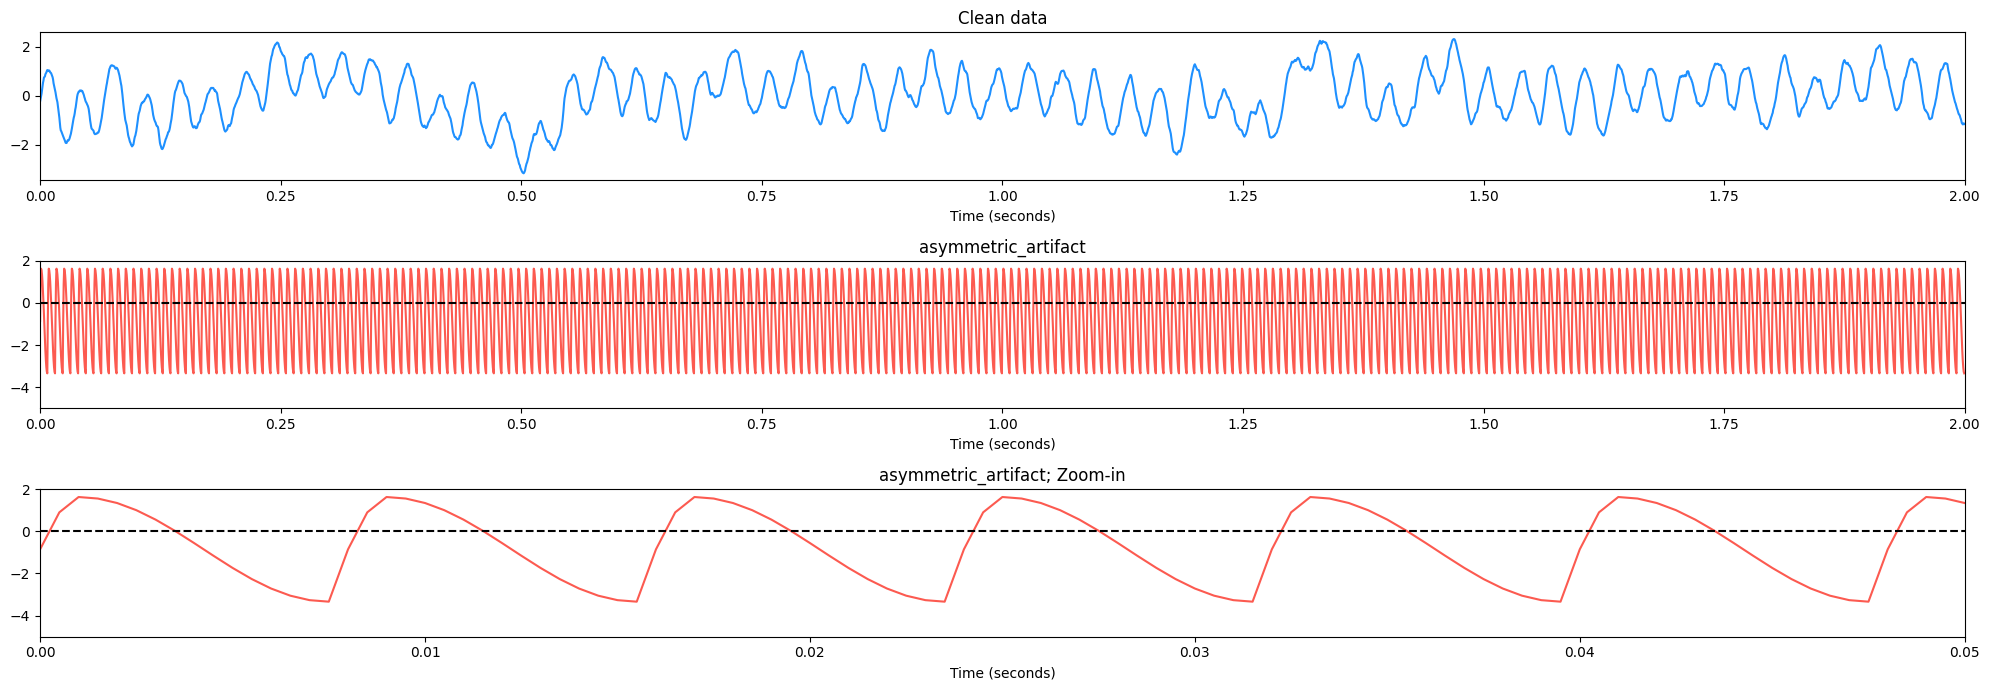

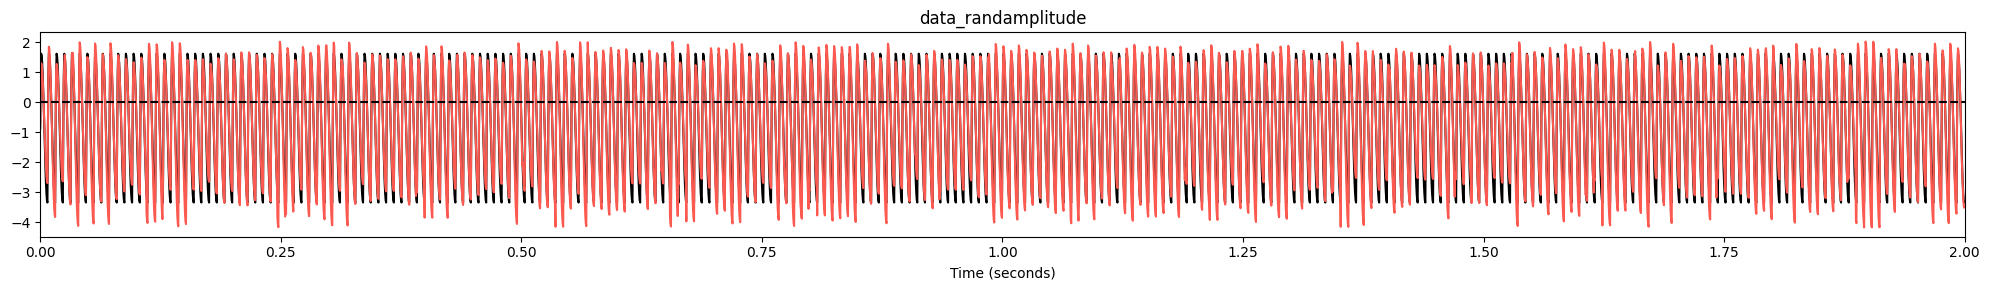

In [32]:
plt.figure(figsize=(20, 7))

plt.subplot(3, 1, 1)
plt.plot(times, Clean[0, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)"); plt.title('Clean data')

plt.subplot(3, 1, 2)
plt.plot(times, asymmetric_artifact[0, :], c='xkcd:coral'); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)"); plt.title('asymmetric_artifact')

plt.subplot(3, 1, 3)
plt.plot(times, asymmetric_artifact[0, :], c='xkcd:coral'); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 0.05])
plt.xlabel("Time (seconds)"); plt.title('asymmetric_artifact; Zoom-in')

plt.tight_layout()

##
plt.figure(figsize=(20, 3))

plt.plot(times, asymmetric_artifact[0, :], c='k')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)")
plt.plot(times, randamplitude_artifact[0, :], c='xkcd:coral')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('data_randamplitude')

plt.tight_layout()

print('data_randamplitude shape:', randamplitude_artifact.shape)

data_signal shape: (100, 4000)
signal_with_artifact shape: (100, 4000)


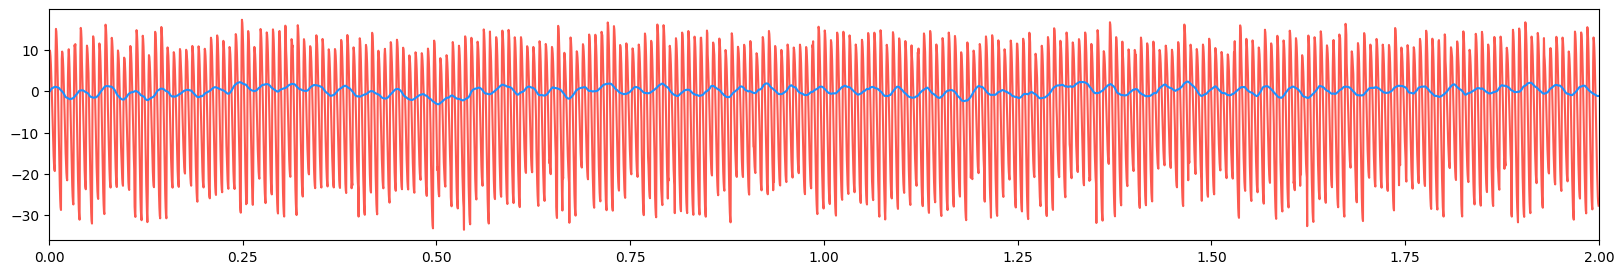

In [33]:
plt.figure(figsize=(20, 3))
plt.plot(times, Contaminated[0, :], c='xkcd:coral')
plt.plot(times, Clean[0, :], c='dodgerblue')
plt.xlim([0, 2])

print('data_signal shape:', Clean.shape)
print('signal_with_artifact shape:', Contaminated.shape)
print('data_signal shape:', Clean[0:10000, :].shape)
print('data_signal shape:', Clean[10000:12000, :].shape)

In [35]:
# -------- < 저장 > ------------------------------------------------

fpath1 = "C:/Users/stell/OneDrive/바탕 화면/paper_data/"
fpath2 = "../../data/evaluation_data/"
# fpath = "../data/paper_data/"

# -------- < data > ------------------------------------------------

np.save(fpath1 + "clean_data" + ".npy", Clean[0:10000, :])
np.save(fpath1 + "contaminated_by_realistic" + ".npy", Contaminated[0:10000, :])

np.save(fpath2 + "clean_data" + ".npy", Clean[10000:12000, :])
np.save(fpath2 + "contaminated_by_realistic" + ".npy", Contaminated[10000:12000, :])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/stell/OneDrive/바탕 화면/paper_data/clean_data.npy'